In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from os import path
import pickle
from astropy import units

from py21cmsense import PowerSpectrum, Observation, Observatory, hera, GaussianBeam, conversions

In [18]:
# Create a Sensitivity that mimics original 21cmSense defaults.
sensitivity = PowerSpectrum(
    observation = Observation(
        observatory = Observatory(
            antpos = hera(hex_num=7, l=14, dl=12.12),
            beam = GaussianBeam(frequency=135.0, dish_size=14),
            latitude=38.5*np.pi/180.0,
            Trcv=1e5
        ),
        n_days=180,
        hours_per_day=6,
        bandwidth=8,
        n_channels=82,
        integration_time=60.0,
        tsky_amplitude=60000,
        tsky_ref_freq = 300,
        spectral_index=2.55
    )
)
observation = sensitivity.observation
observatory = observation.observatory
beam = observatory.beam

In [3]:
# read in gridding file from original 21cmSense
orig_path = "/home/steven/Documents/Projects/radio/EOR/OthersCodes/21cmSense2"
orig_grid_data = np.load(path.join(orig_path, "hera127drift_blmin0_blmax84_0.135GHz_arrayfile.npz"))
with open(path.join(orig_path, "hera127drift_blmin0_blmax84_0.135GHz_arrayfile.pkl"), 'rb') as fl:
    orig_uvbins_data = pickle.load(fl, encoding='latin1')

In [4]:
# ensure several things look the same
print("Trx (new, old): ", observatory.Trcv, orig_grid_data['Trx'])
print("freq (new, old): ", observation.frequency, orig_grid_data['freq'])
print("intg time (new, old): ", observation.integration_time, orig_grid_data['t_int'])
print("obs_duration (new, old): ", observation.obs_duration, orig_grid_data['obs_duration'])
print("dish_size_in_lambda (new, old): ", beam.dish_size_in_lambda(), orig_grid_data['dish_size_in_lambda'])

Trx (new, old):  100000.0 mK 100000.0
freq (new, old):  135.0 MHz 0.135
intg time (new, old):  60.0 s 60.0
obs_duration (new, old):  38.44340956870908 min 38.470023387355276
dish_size_in_lambda (new, old):  6.304361399245074 7.0


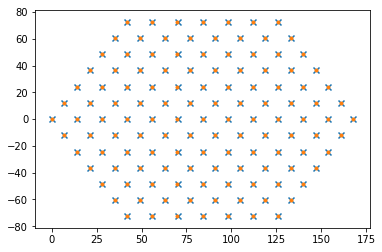

In [20]:
# ensure antenna positions look the same
old_antpos = np.array(orig_uvbins_data['antpos'])

plt.scatter(sensitivity.observation.observatory.antpos[:,0], sensitivity.observation.observatory.antpos[:,1], marker='x', label="Mine")
plt.scatter(old_antpos[:,0]*0.2997, old_antpos[:,1]*0.2997, label='Original', marker='.');

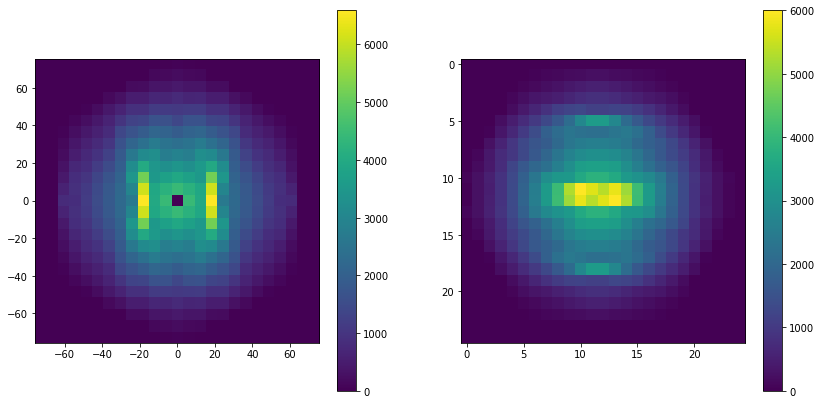

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))

img = ax[0].imshow(observation.uv_coverage, extent=(observation.ugrid.min(), observation.ugrid.max())*2)
plt.colorbar(img, ax=ax[0])

img = ax[1].imshow(orig_grid_data['uv_coverage'])
plt.colorbar(img, ax=ax[1])

The difference here looks quite stark, but really just comes down to the baselines being slightly different due to using proper value of $c$, and rotation synthesis being slightly different.

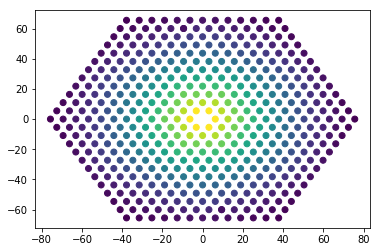

In [32]:
plt.scatter(sensitivity.observation.baseline_group_coords[:,0] * sensitivity.observation.observatory.metres_to_wavelengths, 
            sensitivity.observation.baseline_group_coords[:,1]* sensitivity.observation.observatory.metres_to_wavelengths, 
            c=sensitivity.observation.baseline_group_counts)

In [33]:
with open(path.join(orig_path, 'hera127drift_mod_0.135.pkl'), 'rb') as fl:
    old_sense = pickle.load(fl, encoding='latin1')

/home/steven/miniconda3/envs/21cmSense/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


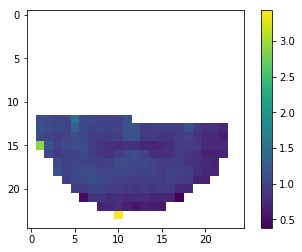

In [36]:
plt.imshow(sensitivity.observation.Trms.value.T/old_sense['TRMS'])
plt.colorbar();

In [37]:
old_sense['scalar'], sensitivity.X2Y

(570137344317.549, <Quantity 5.13382019e+08 Mpc3 / (littleh3 MHz rad2)>)

These are a little different, so we expect some differences in the power spectrum.

In [38]:
def make_2d_power(sense2d, kparallel):
    keys = list(sorted(sense2d.keys()))
    x = np.array([getattr(v, 'value',v)  for v in keys])
    x = np.repeat(x, len(kparallel)).reshape((len(x), len(kparallel))).T
    y = np.fft.fftshift(np.repeat(kparallel, x.shape[1]).reshape((len(kparallel), x.shape[1])))
    C = np.array([np.fft.fftshift(sense2d[key]) for key in keys]).T
    
    plt.pcolormesh(x,y,np.log10(C))
    cbar = plt.colorbar()
    cbar.set_label("$\log_{10} \delta \Delta^2$ [mK^2]", fontsize=14)
    plt.xlabel("$k_\perp$ [h/Mpc]", fontsize=14)
    plt.ylabel("$k_{||}$ [h/Mpc]", fontsize=14)
    
def make_1d_powercut(sense2d, kparallel, k):
    indx = np.where(kparallel>=k)[0][0]
    return [v.value if hasattr(v, "value") else v for v in sense2d.keys()], [val[indx].value if hasattr(val[indx], "value") else val[indx] for val in sense2d.values()]

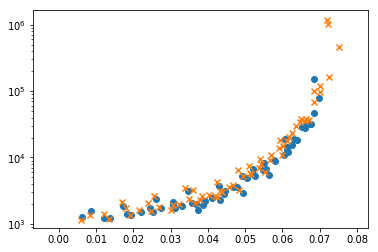

In [39]:
myk, mysense = make_1d_powercut(sense_forced.calculate_sensitivity_2d(sample=False), observation.kparallel.value, 1.0)
hisk, hissense = make_1d_powercut(old_sense['Tsense'], old_sense['kparallels'], 1.0) 
plt.scatter(np.array(myk), np.array(mysense))
plt.scatter(hisk, np.array(hissense), marker='x')
plt.yscale('log')

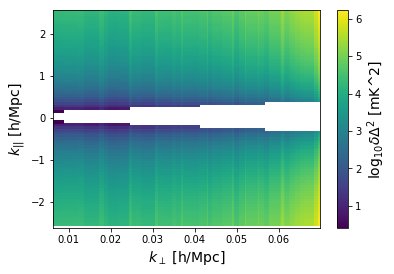

In [40]:
make_2d_power(sensitivity.calculate_sensitivity_2d(sample=False), observation.kparallel)

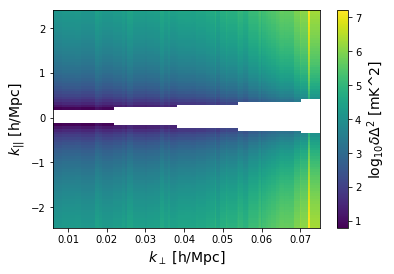

In [41]:
make_2d_power(old_sense['Tsense'], old_sense['kparallels'])

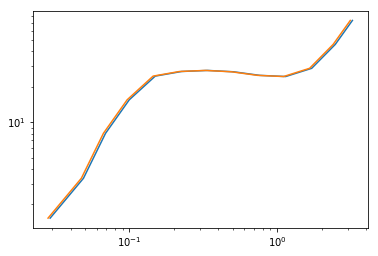

In [42]:
plt.plot(sensitivity.k_21, sensitivity.delta_21)
plt.plot(old_sense['mk'], old_sense['mpk'])
plt.xscale('log')
plt.yscale('log')

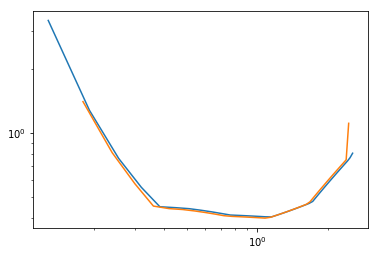

In [43]:
plt.plot(sensitivity.k1d, sensitivity.calculate_sensitivity_1d(thermal=False))
plt.plot(old_sense['ks'], old_sense['C_errs'])
plt.xscale('log')
plt.yscale('log')

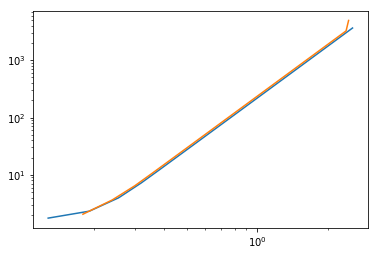

In [44]:
plt.plot(sensitivity.k1d, sense_forced.calculate_sensitivity_1d(sample=False))
plt.plot(old_sense['ks'], old_sense['T_errs'])
plt.xscale('log')
plt.yscale('log')